# Introduction 

- **BACKGROUND**: *wisdom of the crowd* --> if you aggregate the predictions of a group of predictors, you will often get better predictions than with the best individual predictor
- a group of predictors is called an *ensemble*; thus, this technique is called *Ensemble Learning*, and an Ensemble Learning algorithm is called an *Ensemble method* 
--- 
- **RANDOM FORESTS**: you can train a group of Decision Tree classifiers, each on a different subset of the training set --> to make predictions, you obtain the predictions of all the individual Decision Trees, then predict the class that gets the most votes --> this is called a *Random Forest*
---
- **WHEN TO USE**: you will often used Ensemble methods near the end of a project once you have already built a few good predictors, to combine them into an even better predictor

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers (different algorithms, same data)

- a majority-vote classifier is called a *hard voting* classifier
- even if each classifier is a *weak learner*, the ensemble can still be a *strong learner*

In [0]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


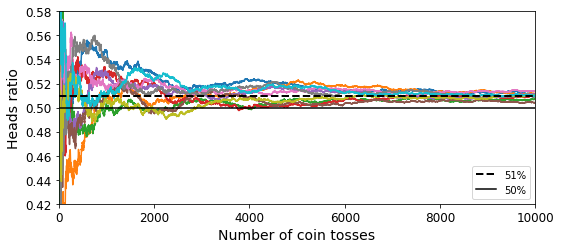

In [86]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

THEORY/APPLICATION
- above is an example of *the law of large numbers*
- Similarily, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for 75% accuracy. 
- **Ensemble methods work best when the predictors are as independent from one another as possible**. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very differnet types of errors, improving the ensemble's accuracy.

ENSEMBLE LEARNING EXAMPLE (voting classifier)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# default models
log_clf = LogisticRegression(solver="lbfgs", random_state=42)       # solver="lbfgs" --> default
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42) # n_estimators=100 --> default
svm_clf = SVC(gamma="scale", random_state=42)                       # gamma="scale" --> default

# ensemble model (combining the default models into 1 model)
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [0]:
voting_clf.fit(X_train, y_train);

In [90]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


- the voting classifier outperformed the individual classifiers

HOW TO ENABLE SOFT VOTING (GENERALLY MORE ACCURATE THAN HARD VOTING (DEFAULT))
- the example above uses hard voting (majority-voting)
- **If all classifiers can estimate class probabilities (if they have a dict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers** (soft voting)
- ***Soft Voting arrives at the best result by averaging out the PROBABILITIES derived by all the individual algorithms***
- To do so, change voting="hard" to voting="soft" and ensure that all classifiers can estimate class probabilities. SVC cannot by default, so set its probability hyperparameter to True.


In [91]:
# SOFT VOTING (can only be done when all classifiers can calculate class probabilities)
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                               

In [92]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) # a higher score was achieved (92)

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting Ensemble Methods (same algorithms, random subsets of data) (parallel learning)

INTRODUCTION TO BAGGING AND PASTING (TRAINING SEVERAL PREDICTORS ON DIFFERENT RANDOM SAMPLES OF THE TRAINING SET)
- as discussed, one way to get a diverse set of classifiers (and therefore a stronger ensemble model) is to use very different training algorithms on the same data
- **GENERAL DEFINITION**: another method to building a good ensemble model is to use the same training algorithm (for every predictor) and train them on different random subsets of the training set
--- 
- *bagging*: when sampling is performed *with* replacement
- *pasting*: when sampling is performed *without* replacement (each subset of the dataset can only be used once at most) --> originally designed for big datasets
- pasting better with super large datasets
- **both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor**
---
- once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions for all predictors (aggregation function is the *statistical mode* - the most frequent prediction)
- aggregation reduces bias and variance
- general result: ensemble has a similar bias but a lower variance than a single predictor trained on the original training set
- **bagging and pasting methods scale very well**

In [0]:
# BAGGING EXAMPLE
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
                                                               # n_jobs=-1 --> train on all available CPU cores (any other # specifies the specific number of CPU cores)
bag_clf = BaggingClassifier(                                   # max_samples=100 --> each Decision Tree trained on 100 training instances
    DecisionTreeClassifier(random_state=42), n_estimators=500, # n_estimators=500 --> ensemble of 500 Decision Trees
    max_samples=100, bootstrap=True, random_state=42)          # bootstrap=True --> bagging method | bootstrap=False --> pasting method (sampling w/o replacement)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- the code above trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement 
- **BaggingClassifier automatically performs soft voting if the basic classifiers can estimate class probability**

In [94]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [95]:
# SINGLE DECISION TREE (WORSE THAN OUR BAGGING ENSEMBLE METHOD MODEL)
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [0]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


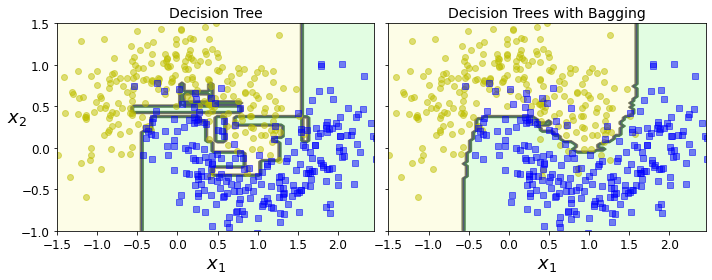

In [97]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

- bagging ensemble of 500 trees generalizes better than a single decision tree
- the ensemble has a comparable bias, but smaller variance (makes a similar amount of errors, but the decision boundary is less irregular) 
---
- bagging tends to have slightly higher bias than pasting
- **bagging often results in better models**, however, if you have spare time and CPU power, you can use cross-validation to evluate both bagging and pasting and select one that works best

OUT-OF-BAG EVALUATION
- with bagging, only 63% of training instances are sampled on average for each predictor wwhile the remaining 37% of the training instances are called *out-of-bag* (oob) instances 
- the oob instances are not the same 37% for all predictors
- **since a predictor never sees the oob instances during training, it can be evaluated on these instances without the need for a separate validation set** (you can evaluate the ensemble manually by averaging out the oob evaluations for each predictor). 
- use oob_score=True w/ BaggingClassifier to request an automatic oob evaluation after training --> available through the oob_score_variable

In [98]:
# BAGGING EXAMPLE w/ OOB SCORE 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
                                                               # n_jobs=-1 --> train on all available CPU cores (any other # specifies the specific number of CPU cores)
bag_clf = BaggingClassifier(                                   # max_samples=100 --> each Decision Tree trained on 100 training instances
    DecisionTreeClassifier(random_state=42), n_estimators=500, # n_estimators=500 --> ensemble of 500 Decision Trees
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=42)# bootstrap=True --> bagging method | bootstrap=False --> pasting method (sampling w/o replacement)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [99]:
# WAS THE OOB SCORE AN ACCURATE PREDICTION?
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

RANDOM PATCHES AND RANDOM SUBSPACES (FEATURE SAMPLING) 

- **with the BaggingClassifier, sampling is controlled by max_features and boostrap_features** --> they work the same way as max_samples and boostrap, but for feature sampling instead of instance sampling
- sampling features is particularly useful when dealing with high-dimensional inputs such as images 
- sampling both instances AND features is called the *Random Patches* method
- Keeping all training instances (boostrap=False and max_samples=1.0) but sampling features (bootstrap_features=True and max_features=(value less than 1) is called *Random Subspaces*

# Random Forests (basically bagging w/ decision trees)

- a Random Forest is an ensemble of Decision Trees, generally trained using BaggingClassifier and w/ max_samples=(size of training set)
- instead of using BaggingClassifier w/ DecisionTreeClassifier, instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees

In [100]:
from sklearn.ensemble import RandomForestClassifier

# 500 Decision Trees, each limited to a maximum of 16 leaf nodes
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

- ***RandomForestClassifiers have the hyperparameters of a Decision Tree and a BaggingClassifier combined***
- **Random Forests introduce extra randomness when growing trees**; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features
- ***the algorithm results in greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model***

EXTRA-TREES

- it is possible make trees even more trandom
- this is called an *Extremely Randomized Trees* ensemble (*Extra-Trees* for short) 
- once again, this technique trades higher bias for lower variance
- Extra-Trees are also much faster to train than regular Random Forests
- use Scikit-Learn's ExtraTreesClassifier (same API as RandomForestClassifier)

In [0]:
from sklearn.ensemble import ExtraTreesClassifier # sklearn.ensemble is the API

FEATURE IMPORTANCE

- Random Forests make it easy to measure the importance of each feature
- Scikit-Learn computes this score automatically for each feature after training
- sum of all importances is equal to 1
- you can access the result using feature_importances_
- **Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection** 

In [102]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [0]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [104]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


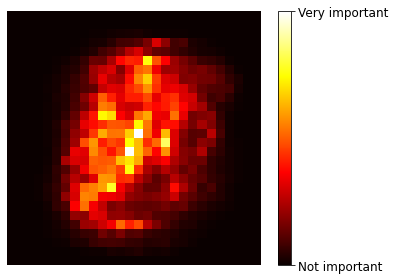

In [106]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting (AdaBoost) (sequential learning)

BOOSTING

- *Boosting* refers to any Ensemble method that can combine several weak learners into a strong learner --> *AdaBoost* (short for *Adaptive Boosting*) and *Gradient Boosting* are the most popular boosting methods

ADABOOST

- When training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances, then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on. 

Saving figure boosting_plot


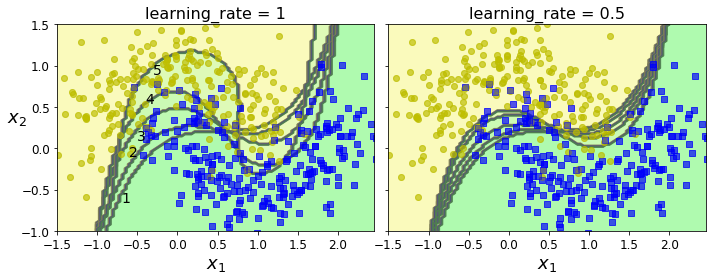

In [107]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

- graphs of decision boundaries of five consecutive predictors on the moons dataset 
- the plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., misclassified instance weights are boosted half as much at every iteration)
- **AdaBoostClassifier is a sequential learning technique**
- **drawback: cannot be parallelized**, since each predictor can only be trained after the previous predictor has been evaluated/trained
- **does not scale as well as Bagging/Pasting**
- algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found
- the predicted class is the one that receives the majority of weighted votes
---
FOR MANY CLASSES

- Scikit-Learn has a multiclass version of AdaBoost called SAAME (*Stagewise Additive Modeling using a Multiclass Exponential loss function*) 
- if the predictors can estimate class probabilities, use SAAME.R (R="real"), which relies on class probabilities rather than predictions and generally performs better

In [108]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

# Boosting (Gradient)

- **sequentially adds predictors to an ensemble, each one correcting its predecessor** (like AdaBoost), however, instead of tweaking the instance weights at every iteration (like AdaBoost), **Gradient Boosting tries to fit the new predictor to the *residual errors* made by the previous predictors**

In [0]:
# NOISY QUADRATIC TRAINING SET
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [110]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [111]:
# SECOND DecisionTreeRegressor TRAINED ON THE RESIDUAL ERRORS OF FIRST PREDICTOR
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [112]:
# THIRD DecisionTreeRegressor TRAINED ON THE RESIDUAL ERRORS OF SECOND PREDICTOR
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
X_new = np.array([[0.8]])

In [114]:
# ENSEMBLE CONTAINING 3 TREES --> ADDS UP PREDICTIONS OF 3 TREES TO MAKE NEW PREDICTIONS
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [0]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


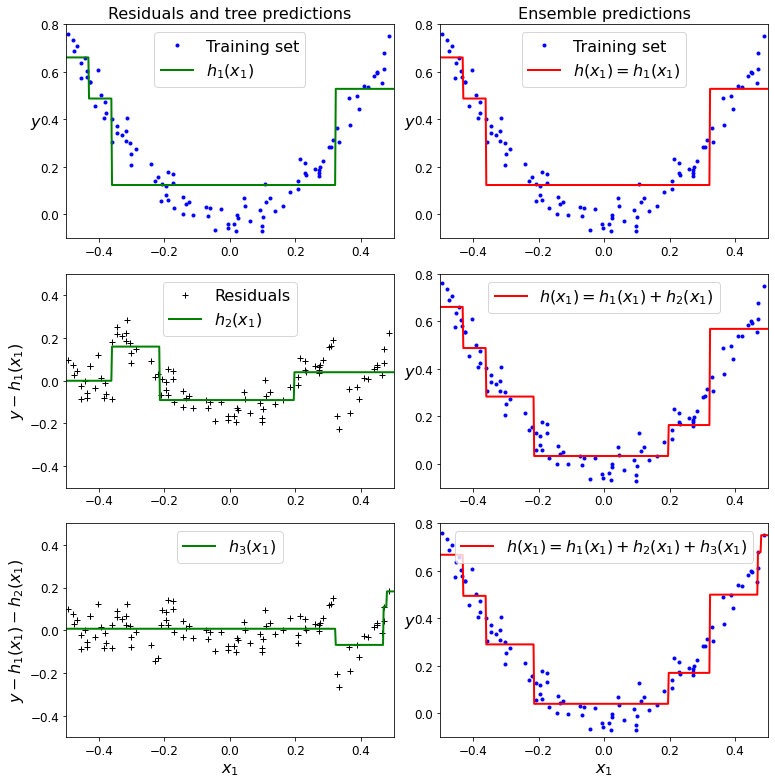

In [116]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

- left: predictions of trees
- right: predictions of ensemble
- each consecutive predictor (middle & lower left) is trained on the previous predictor's residuals
- a simpler way to train a GBRT ensemble is to use Scikit-Learn's GradientBoostingRegressor class --> uses similar hyperparameters to RandomForestRegressor class


In [117]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [118]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

- the learning_rate hyperparameter scales the contribution of each tree
- a low learning rate will require a lot of trees, but will generalize better

Saving figure gbrt_learning_rate_plot


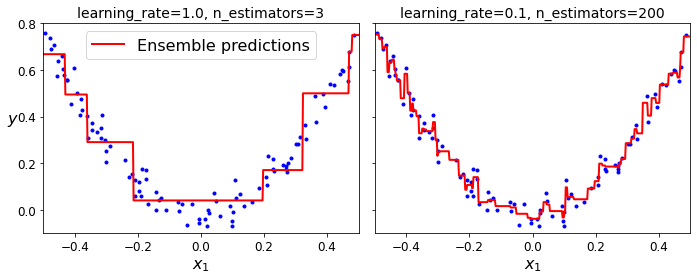

In [119]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

- left: not enough trees (underfitting)
- right: too many trees (overfitting)
---
***FINDING THE OPTIMAL AMOUNT OF TREES***:
- use early stopping (staged_predict() method as shown below)

In [120]:
# TRAIN A LARGE AMOUNT OF TREES THEN LOOK BACK TO FIND THE OPTIMAL NUMBER
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


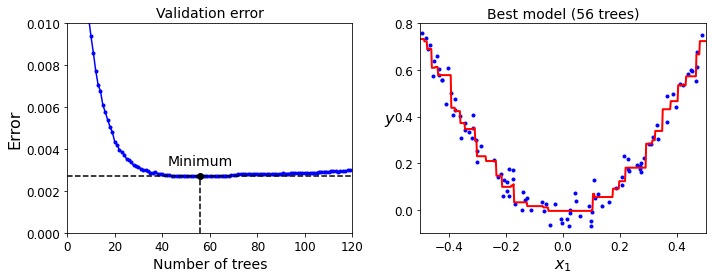

In [122]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [0]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [124]:
print(gbrt.n_estimators)

61


***STOCHASTIC GRADIENT BOOSTING***
- higher bias for lower variance
- tweaking the subsample hyperparameter
- subsample=0.25 --> each tree is trained on 25% of training instances (selected randomly)
- speeds up training considerably

***XGBOOST***
- an optimized implementation of Gradient Boosting is available in the popular Python library XGBoost, which stands for *Extreme Gradient Boosting*

In [125]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[06:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


- XGBoost also offers several nice features, such as automatically taking care of early stopping:

In [126]:
xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[06:17:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

# Stacking Ensemble (similar to previous ensembles but +blender)

- *Stacked Generalization*
- **instead of using** trivial functions (such as hard **voting**) to aggregate the predictions of all predictors in an ensemble, **train a separate model to perform this aggregation**
- each of the predictors predicts a value, and then the final predictor (called a *blender*, or a *meta learner*) takes these predictions as inputs and makes the final prediction
- blenders trained using a hold-out set: training set split into 2 subsets, then first subset used to train predictors, then these predictors make predictions on the second (held-out) set --> a third training set is then created out of these predictions, in which the blender uses it to train
- Scikit-Learn does not directly support Stacking

# Exercises

1) **VOTING ENSEMBLE APPLICATION**

Yes, if five different models all trained on the same data each achieved 95% precision, you can try combining them into a **voting ensemble, which will often give you even better results** (most effective when models are independent --> very different algorithms and/or if they are trained on different training instances, but that's kinda the point of bagging/pasting ensembles). 

2) **HARD/SOFT VOTING**

**hard voting**: counts votes of each classifier in ensemble and picks class w/ most votes

**soft voting**: computes averages of each class, then picks class with highest probability 

Soft voting often works better, however, each classifier must be capable of measuring class probabilities for the ensemble to perform soft voting.

3) **PARALLEL vs. SEQUENTIAL vs. STACKING (ALGORITHMS)**

distributing training of bagging/pasting/randomforests across multiple servers works because they are parallel learning algorithms

each predictor in a boosting ensemble is built based on the previous predictor, so training is sequential, so therefore, server distribution would not speed up training

with stacking, each layer of predictors is trained independently, however, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained

4) **OUT-OF-BAG EVALUATION**

out-of-bag evaluation works with bagging ensembles

each predictor in a bagging ensemble is evaluated using instances that were they were not trained on, which makes it possible to get a fairly unbiased evaluation without the need for an additional evaluation set

thus, you have more training instances, and your model can perform slightly better

5) **EXTRA TREES**

decision trees in random forests only consider a random subset of features for splitting at each node

extra trees, however, go one more step of randomness further --> instead of looking for each feature's best threshold, they use random thresholds for each feature

these extra trees act as a form of regularization --> if a random forest is overfitting, extra trees might perform better

extra trees are also much faster to train

6) **ADABOOST ENSEMBLE**

if adaboost ensemble is underfitting, try increasing the number of predictors or reducing regularization hyperparameters... or even try increasing the learning rate

7) **GRADIENT BOOST ENSEMBLE**

if gradient boosting ensemble is overfitting, try decreasing the learning rate or the number of predictors 

you could also use early stopping to find the right number of predictors (again, you probably have too many)

### 8) Voting Classifier

Exercise: _Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# training set, validation set, and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

- train various classifiers

In [0]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [0]:
# the predictors
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42) # default
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42) # default
svm_clf = LinearSVC(random_state=42) # default
mlp_clf = MLPClassifier(random_state=42) # default (ooOoOo what is this guy?) --> multi-layer perceptron classifier 

In [134]:
# individual training evaluations
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf] # the predictors
for estimator in estimators: 
  print("Training the", estimator)
  estimator.fit(X_train, y_train)

Training the RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                 

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [135]:
[estimator.score(X_val, y_val) for estimator in estimators] # validation set

[0.9692, 0.9715, 0.8397, 0.9639]

- svm is outperformed, but keep it because still may improve overall model precision

- now make ensemble classifier

In [0]:
from sklearn.ensemble import VotingClassifier

In [0]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [138]:
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [140]:
voting_clf.score(X_val, y_val)

0.9706

In [141]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.8397, 0.9639]

- let's try removing svm --> set svm=None in voting_clf hyperparameter to remove it

In [142]:
voting_clf.set_params(svm_clf=None)
voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_base.py:232: FutureWarning: Using 'None' to drop an estimator from the ensemble is deprecated in 0.22 and support will be dropped in 0.24. Use the string 'drop' instead.
  "Use the string 'drop' instead.", FutureWarning


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [143]:
voting_clf.score(X_val, y_val)

0.9736

- now let's use a soft voting classifier
- no need to re-train, just set voting to "soft"

In [145]:
voting_clf.voting="soft"
voting_clf.score(X_val, y_val)

0.97

- nope, hard voting (default) wins

In [146]:
voting_clf.voting="hard"
voting_clf.score(X_test, y_test)

0.9704

In [147]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9604]

- voting classifier only slightly reduced the error rate, but at any rate, it improved things!

### 9) Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [149]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
X_val_predictions

array([[5., 5., 8., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [150]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [151]:
rnd_forest_blender.oob_score_

0.9704

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [0]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [0]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [0]:
from sklearn.metrics import accuracy_score

In [155]:
accuracy_score(y_test, y_pred)

0.9655

- stacking ensemble (with blender) does not perform better than the voting classifier ensemble

# Clarification (score vs accuracyscore)

To clarify:

results.score(X_train, y_train) is the training accuracy, while

accuracy_score(y_test, results.predict(X_test)) is the testing accuracy.

In [169]:
voting_clf.score(X_train, y_train) # perfect 1.0 because trained on this data

1.0

In [158]:
voting_clf.score(X_val, y_val) # less effective because this is the validation set

0.9736

In [170]:
voting_clf.score(X_test, y_test)

0.9704

In [159]:
accuracy_score(y_test, voting_clf.predict(X_test)) # test set!

0.9704